In [ ]:
!pip install quantstats

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.3/41.3 kB 1.9 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
import quantstats as qs

from typing import Union
from datetime import datetime

import warnings
warnings.filterwarnings('ignore')



```
# Ce texte est au format code
```

# Double Short Strategy
Leverage decay or beta-slippage is a phenomenon whereby both long and short leveraged funds will suffer when the underlying asset is volatile, but with no change in value. Shorting both sides of a leveraged ETF pair has therefore been proposed as a strategy to profit from this decay in a market-neutral fashion.

This particular back test only contains one signal; when the expected given realized volatility of the underlying ETF (benchmark) is greater than the current annual implied volatility of the underlying ETF. The stop-loss is set to be the previous high of the underlying ETF, and the target is the expected decay over a given period. The expected decay is outlined in Cheng and Madhavan (2009)
$$
r_x = (1+\mu)^xe^{\frac{(x-x^2)\sigma^2t_N}{2}}
$$
With $x$ being the leverage factor, $r_x$ the expected return of the leveraged product, $\mu$ the daily expected return (annual divided by number of days), $\sigma$ the daily expected standard deviation (annual divided by square-root of days), and $t_N$ the number of days (e.g. 252).

This gives exact same values as the ones reported by Proshares in their prospectus (ProShares manages the LETFs we use).


#### Trading Pairs Class
Define several trading pairs. Each pair contains the two LETFs that track the same index. One is negetively correlated, the other is positivley correlated.

In [ ]:
class TradingPair:
    def __init__(self, underlying: str, LETFs, leverage: int, start: str, end: str,
                times: list):
        self.underlying = underlying
        self.neg_letf = LETFs[0]
        self.pos_letf = LETFs[1]
        self.leverage = leverage
        self.times = times

        self.data = pd.DataFrame(columns=[self.underlying, self.neg_letf, self.pos_letf])

        #self.borrow = pd.read_csv()

        self.pct_return: pd.DataFrame = None
        self.comm_returns: pd.DataFrame = None
        self.decay: pd.DataFrame = pd.DataFrame()
        self.volatility: pd.DataFrame = pd.DataFrame()

        self.strategy = None

        self.trades = None
        self.start = start
        self.end = end

    '''
    -----------------------
    -------- DATA ---------
    -----------------------
    '''

    def load_data(self):
        self.data[self.underlying] = yf.download(self.underlying,
                                    start=self.start, end = self.end)['Adj Close']
        self.data[self.neg_letf] = yf.download(self.neg_letf,
                                    start=self.start, end = self.end)['Adj Close']
        self.data[self.pos_letf] = yf.download(self.pos_letf,
                                    start=self.start, end = self.end)['Adj Close']
        self.pct_return = self.data.pct_change().dropna()
        #print(self.pct_return)
        self.comm_returns = 1 + (self.pct_return+1).cumprod()-1
        self.data.dropna(inplace=True)
        self.pct_return.dropna(inplace=True)
        self.comm_returns.dropna(inplace=True)

    def __load_implied_volatility(self):
        data = pd.read_csv(f'Data/{self.underlying}_imp_vol.csv')
        data.columns = ['date', 'imp. vol']
        if len(self.volatility) < len(data):
            data = data[len(data)-len(self.volatility):]
        else:
            self.volatility = self.volatility[len(self.volatility)-len(data):]
        data.index = self.volatility.index
        self.volatility['Annual imp vol'] = data['imp. vol']

    '''
    -----------------------
    -------- DECAY --------
    -----------------------
    '''

    def expected_decay(self):
        x       = self.leverage
        T       = 252
        mu      = self.pct_return[self.underlying].rolling(T).mean()
        sigma   = self.pct_return[self.underlying].rolling(T).std()
        r       = (1+mu)**x * np.exp(((x-x**2)*sigma**2*T)/2)

        self.volatility['E(annual) realized']   = sigma*(T**0.5)
        self.decay['E(annual) realized']        = r
        self.volatility.dropna(inplace=True)
        self.decay.dropna(inplace=True)

        # Add implied volatility
        #self.__load_implied_volatility()


    def predicted_decay(self):
        times   = self.times
        x       = self.leverage
        T       = 255
        for t in times:
            mu      = self.pct_return[self.underlying].rolling(t).mean()
            sigma   = self.pct_return[self.underlying].rolling(t).std()
            r       = (1+mu)**x * np.exp(((x-x**2)*sigma**2*t)/2)

            self.volatility[f'E({t}D realized)'] = sigma*(T**0.5)
            self.decay[f'E({t}D) realized']      = r
        self.volatility.dropna(inplace=True)
        self.decay.dropna(inplace=True)



    '''
    --------------------------
    -------- BACKTEST --------
    --------------------------
    '''

    def backtest(self, ratio=2/3, rel_vol_len=45):
        # Format data so the dates (length) match
        self.data = self.data[len(self.data)-len(self.volatility):]
        self.strategy = DoubleShortStrategy(self, ratio, rel_vol_len)
        self.strategy.run()

    '''
    --------------------------
    -------- PLOTTING --------
    --------------------------
    '''

    def plot_intra_day_roi(self):
        plt.plot(self.strategy.result.intra_day_roi);
        plt.xticks(rotation=45);
        plt.title('Portfolio daily ROI');
        plt.grid()
        plt.show()

    def max_drawdown(self):
        plt.plot(self.strategy.result.intra_day_roi.cumsum(), label='return');
        plt.plot(self.strategy.result.intra_day_roi.cummax(), 'max return');
        plt.xticks(rotation=45);
        plt.title('Drawdown');
        plt.grid()
        plt.show()

    def plot_roi(self):
        # plt.plot(self.strategy.result.roi.cumsum());
        plt.plot(self.strategy.result.cum_roi);
        plt.xticks(rotation=45);
        plt.title('Portfolio total ROI');
        plt.grid()
        plt.show()

    def plot_vol(self):
        plt.plot(self.strategy.result.intra_day_roi.rolling(5).std()*np.sqrt(255));
        plt.xticks(rotation=45);
        plt.title('Portfolio Volatility');
        plt.grid()
        plt.show()

    def plot_price(self):
        plt.plot(self.data);
        plt.legend(list(self.data.columns));
        plt.xticks(rotation=45);
        plt.title('Adj Close');
        plt.grid()
        plt.show()

    def plot_cumm_returns(self):
        plt.plot(self.comm_returns);
        plt.legend(list(self.comm_returns.columns));
        plt.xticks(rotation=45);
        plt.title('Commulative returns');
        plt.grid()
        plt.show()

    def plot_decay(self):
        plt.plot(self.decay);
        plt.legend(list(self.decay.columns));
        plt.xticks(rotation=45);
        plt.title('Decay');
        plt.grid()
        plt.show()

    def plot_volatiltiy(self):
        plt.plot(self.volatility);
        plt.legend(list(self.volatility.columns));
        plt.xticks(rotation=45);
        plt.title('Volatility');
        plt.grid()
        plt.show()




**Retrieve Data**
* Start with SPX ETF

**Possible Entry Signals**

1. Entry signal #1
* whenever the 45 day realized volatility is lower than the 10 day realized volatility


2. Entry signal #2:
* whenever the 30 day realized vol is lower than the 5 day realized vol

3. Entry signal #3:
* whenever the 5 day realized volatility is lower than implied volatility

#### Double Short Strategy class

In [ ]:
class DoubleShortStrategy():

    def __init__(self, trading_pair, ratio=1, realized_vol_signal=None):
        self.trading_pair = trading_pair
        self.in_trade  = False
        self.stop_loss = None # from underlying
        self.entry     = {} # leveraged etfs
        self.shares    = {} # leveraged etfs shares
        self.target    = None # from underlying
        self.result    = pd.DataFrame(index=self.trading_pair.data.index,
                                   columns = ['intra_day_roi'])
        self.ratio     = ratio

        self.target = 0
        self.lastBought = 0
        self.bought = 0


    def run(self):
        tickers = [x for x in self.trading_pair.data]
        print('Simulating strategy for', tickers, '\n')

        short_time_horizon = 5
        long_time_horizon = 30

        vol_df = pd.DataFrame(columns=[str(short_time_horizon) + 'd_volatility', str(long_time_horizon) + 'd_volatility'])
        #vol_df[str(short_time_horizon) + 'd_volatility'] = self.trading_pair.data[self.trading_pair.underlying].rolling(window=short_time_horizon).std() / self.trading_pair.data[self.trading_pair.underlying].rolling(window=short_time_horizon).mean()

        vol_df[str(short_time_horizon) + 'd_volatility'] = self.trading_pair.pct_return[self.trading_pair.underlying].rolling(window=short_time_horizon).std() * np.sqrt(252)

        #vol_df[str(long_time_horizon) + 'd_volatility'] = self.trading_pair.data[self.trading_pair.underlying].rolling(window=long_time_horizon).std() / self.trading_pair.data[self.trading_pair.underlying].rolling(window=long_time_horizon).mean()

        vol_df[str(long_time_horizon) + 'd_volatility'] = self.trading_pair.pct_return[self.trading_pair.underlying].rolling(window=long_time_horizon).std() * np.sqrt(252)

        #print(vol_df)

        self.signals = []

        for date in self.trading_pair.data.index[500:]:
            #date = date.date()
            df = self.trading_pair.decay
            index = df.index
            #print(type(index))
            # Pass the data up intil this day so we get no look ahead bias
            data = self.trading_pair.data[self.trading_pair.data.index <= date]
            vol = self.trading_pair.volatility[self.trading_pair.volatility.index <= date]
            # print(len(self.trading_pair.decay))

            # decay = self.trading_pair.decay[self.trading_pair.decay.index <= date]
            decay = self.trading_pair.decay
            # print(type(date))
            # print(date)
            # print(type(decay.index[-1]))
            #print(len(decay))
            #print(date)
            signal = self.next(date, data, vol, decay, vol_df, short_time_horizon, long_time_horizon)
            self.signals.append(signal)
            #print(signal)

        # Calculate results
        # print(self.signals)


    def next(self, date, data, vol, decay, vol_df, short, long):

        underlier = self.trading_pair.underlying
        price = data[underlier].iloc[-1]

        #keep track of the decay when we made the buy
        #keep track of last day we bought

        if date == self.trading_pair.start:
          return
        # Implement strategy logic

        #Strategy: enter position whenever 10 day volatility is higher than 45 day volatility

        signal = int(vol_df[str(long) + 'd_volatility'][date] < vol_df[str(short) + 'd_volatility'][date])
        #print(signal)

        if self.bought == 1:
          #check stop loss
          if price >= (self.stop_loss ):
            self.bought = 0
            return -1
          elif price <= self.target:
            #we check the decay both ways, if it increases or decreases by the stop loss pct change; we get out
              self.bought = 0
              # print("Target hit")
              return -1
          else:
              return 1
        #print(len(decay))
        if signal == 1:
          #print(self.lastDecay)


          if self.bought == 0:
            currentCurMax = (1 + (data[underlier].cummax().iloc[-1]))
            #print(currentCurMax)
            self.stop_loss = currentCurMax

            self.target = (1- decay['E(40D) realized'][decay.index == date].iloc[0]) * price
            self.lastBought = date
            self.lastPrice = price

            self.bought = 1
            return 1


        return 0

    # def calculate_risk_reward_ratio(self, data, decay):
    #     pass


    def calculate_stop(self, data):
        return data['Close'].pct_change().cummax().iloc[-1]
    # # number of shares to invest in each asset

    # def calculate_number_of_shares(self, price_neg, price_pos):
    #     pass


**Create Double Strategy object**

In [ ]:
import time
from datetime import datetime, timedelta
import numpy as np
#yf.download()

underlier = 'SPY'
long_etf = 'SPXL'
short_etf = 'SPXS'

end = datetime.now() - timedelta(days=1)
start = end - timedelta(days=2048)


times = np.arange(5, 45)

trading_pair = TradingPair(underlier, [short_etf, long_etf], 3, start, end, times)
trading_pair.load_data()
trading_pair.expected_decay()
trading_pair.predicted_decay()
trading_pair.decay.index = pd.to_datetime(trading_pair.decay.index)
decay = trading_pair.decay

#data = trading_pair.data
#print(data)

double_strategy = DoubleShortStrategy(trading_pair)
double_strategy.run()

signals = double_strategy.signals

amount = 10

data = trading_pair.data
data['signals'] = 0
data['signals'][500:] = signals
bought = 0
ret = []
drawd = []
dy_ret = []
for i in range(len(data)):
  if bought == 1:
    sell_price_pos = data[long_etf].iloc[i]
    sell_price_neg = data[short_etf].iloc[i]
    drawd.append((buy_price_pos+buy_price_neg-sell_price_pos-sell_price_neg)/(sell_price_pos+sell_price_neg))
  if data['signals'].iloc[i] == 1 and bought != 1:
    buy_price_pos = data[long_etf].iloc[i]
    buy_price_neg = data[short_etf].iloc[i]
    bought = 1
  elif data['signals'].iloc[i] == -1:
    sell_price_pos = data[long_etf].iloc[i]
    sell_price_neg = data[short_etf].iloc[i]
    ret.append((buy_price_pos+buy_price_neg-sell_price_pos-sell_price_neg)/(sell_price_pos+sell_price_neg))
    bought = 0

ret = np.array(ret)
risk_free_rate = 0.05
cum_return = np.prod(1 + ret) - 1

print("Cum return: "+ str(cum_return))







[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
Simulating strategy for ['SPY', 'SPXS', 'SPXL'] 

Cum return: 0.5868914971682437


In [ ]:
initial_capital = 10**5
strategy_returns = pd.DataFrame()

# dataframe positions
for ticker in ['SPXL', 'SPXS']:
    positions = pd.DataFrame()
    shares    = (initial_capital/3)/data[ticker].iloc[0]
    positions['position'] = -shares * data['signals']

    # Store it into the variable portfolio
    portfolio = positions.multiply(data[ticker], axis=0)

    # Add `holdings` to portfolio
    portfolio['holdings'] = (positions.multiply(data[ticker], axis=0)).sum(axis=1)

    # Store positions.diff into pos_diff
    pos_diff = positions.diff()

    # initial_capital - (the notional you use for your different buy/sell)
    portfolio['cash'] = initial_capital - (pos_diff.multiply(data[ticker], axis=0)).sum(axis=1).cumsum()

    # Total
    portfolio['total'] = portfolio['cash'] + portfolio['holdings']

    # Add `returns` to portfolio
    strategy_returns[ticker] = portfolio['total'].pct_change()

strategy_returns['total'] = strategy_returns.sum(axis=1)

<Axes: xlabel='Date'>

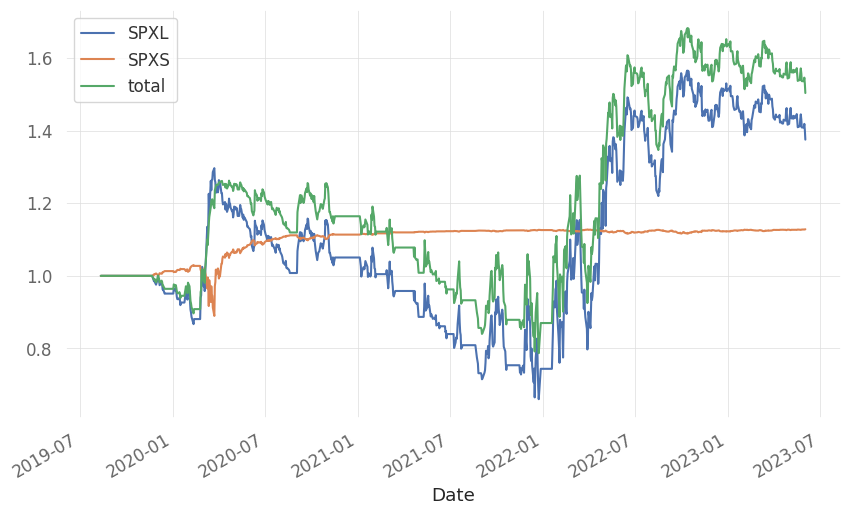

In [ ]:
(1+strategy_returns[450:].cumsum()).plot()

## Compare with a buy and hold strategy containing the 3 ETFS used in the strategy
* 50% invested in SPY
* 25% invested in each of SPXL and SPXY

In [ ]:
buy_and_hold_portfolio              = pd.DataFrame()
buy_and_hold_portfolio['SPY']       = data['SPY'].pct_change()*0.5
buy_and_hold_portfolio['SPXL']      = data['SPXL'].pct_change()*0.25
buy_and_hold_portfolio['SPXS']      = data['SPXS'].pct_change()*0.25
buy_and_hold_portfolio['return']    = buy_and_hold_portfolio.sum(axis=1)


In [ ]:
print(buy_and_hold_portfolio)

                 SPY      SPXL      SPXS    return
Date                                              
2017-10-26       NaN       NaN       NaN  0.000000
2017-10-27  0.004088  0.005908 -0.006221  0.003775
2017-10-30 -0.001862 -0.002552  0.002596 -0.001818
2017-10-31  0.000779  0.000859 -0.000808  0.000831
2017-11-01  0.000661  0.001223 -0.001105  0.000780
...              ...       ...       ...       ...
2023-05-26  0.006475  0.009635 -0.009538  0.006573
2023-05-30  0.000190  0.000032 -0.000150  0.000073
2023-05-31 -0.002773 -0.004054  0.003909 -0.002918
2023-06-01  0.004751  0.006923 -0.006661  0.005013
2023-06-02  0.007231  0.010651 -0.010493  0.007388

[1409 rows x 4 columns]


## Generate results

In [ ]:
print(pd.__version__)

1.5.3


In [ ]:
print(buy_and_hold_portfolio['return'].name)

return


In [ ]:
print(strategy_returns[450:].total.name)

total


In [ ]:
qs.reports.html(strategy_returns[450:].total, buy_and_hold_portfolio['return'],
                output='results.html');